In [ ]:
!wget https://www.kaggle.com/api/v1/datasets/download/puneet6060/intel-image-classification -O dataset.zip

In [ ]:
!unzip dataset.zip

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
train_path = 'seg_train/seg_train'
test_path = 'seg_test/seg_test'

image_size = (224,224)
input_size = (224,224,3)
batch_size = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    validation_split=0.1,
    subset='training',
    seed=23,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=image_size,
    batch_size=32,
    shuffle=True,
    label_mode='categorical',
    subset='validation',
    validation_split=0.1,
    seed=23,
)

data_labels = train_ds.class_names
num_classes = len(data_labels)
print(f"data labels: {data_labels}")
print(f"number of classes: {num_classes}")

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 3000 files belonging to 6 classes.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
data labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
number of classes: 6


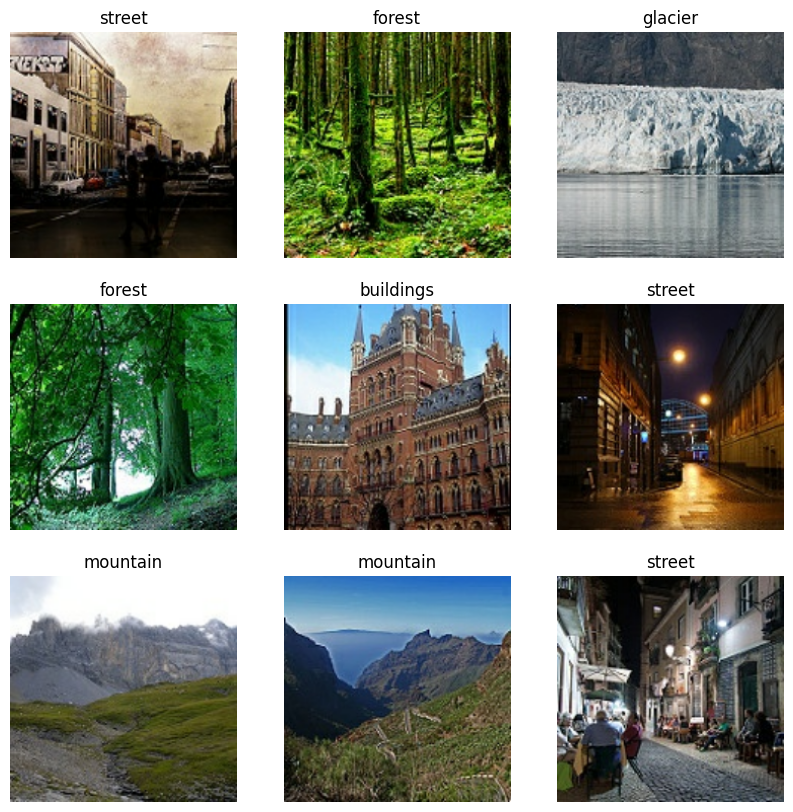

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        ax.imshow(images[i].numpy().astype('uint8'))
        ax.set_title(data_labels[np.argmax(labels[i])])
        ax.axis('off')

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

inputs = Input(shape=input_size)

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

base_model.trainable = False

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.name = 'ResNet50'
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,145,926 (92.11 MB)

 Trainable params: 558,214 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
checkpoint = ModelCheckpoint('best.keras', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8272 - loss: 0.5014
Epoch 1: val_loss improved from inf to 0.55879, saving model to best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 78s 158ms/step - accuracy: 0.8273 - loss: 0.5011 - val_accuracy: 0.8133 - val_loss: 0.5588 - learning_rate: 0.0010
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9243 - loss: 0.2202
Epoch 2: val_loss improved from 0.55879 to 0.51959, saving model to best.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.9243 - loss: 0.2202 - val_accuracy: 0.8254 - val_loss: 0.5196 - learning_rate: 0.0010
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9318 - loss: 0.1838
Epoch 3: val_loss did not improve from 0.51959
395/395 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.9318 - loss: 0.1839 - val_accuracy: 0.8304 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9389 - loss: 0.1678
Epoch 4: Reduce

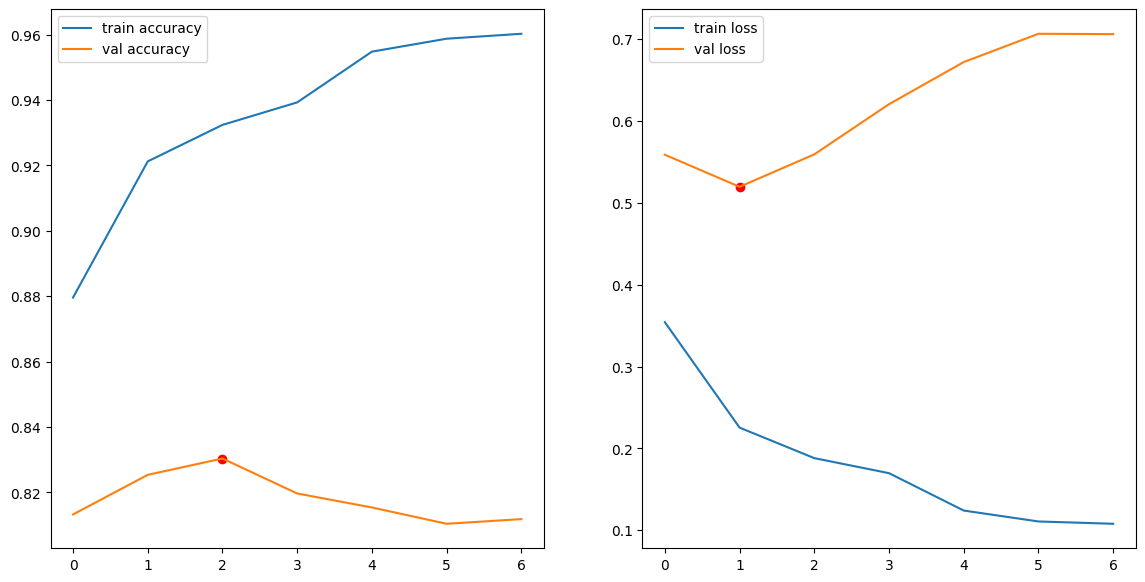

In [12]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
best_acc = np.argmax(history.history['val_accuracy'])
plt.scatter(best_acc, history.history['val_accuracy'][best_acc], color='red')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()

plt.subplot(1,2,2)
best_loss = np.argmin(history.history['val_loss'])
plt.scatter(best_loss, history.history['val_loss'][best_loss], color='red')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

In [13]:
from tensorflow.keras.models import load_model

model = load_model('best.keras')
model.save('scenic.keras')

In [14]:
total_loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {total_loss}")
print(f"Test Accuracy: {accuracy*100}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9292 - loss: 0.2055
Test Loss: 0.21534594893455505
Test Accuracy: 92.1999990940094


In [15]:
from tensorflow.keras.metrics import Precision, Recall

y_true_list = []
y_pred_list = []

precision = Precision()
recall = Recall()

for images, labels in test_ds:
    y_pred = model.predict(images)
    precision.update_state(labels, y_pred)
    recall.update_state(labels, y_pred)
    y_true_list.extend(np.argmax(labels, axis=1))
    y_pred_list.extend(np.argmax(y_pred, axis=1))

f1_score = 2 * (precision.result() * recall.result()) / (precision.result() + recall.result())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━

In [16]:
print(f"Precision: {precision.result().numpy()}")
print(f"Recall: {recall.result().numpy()}")
print(f"F1 Score: {f1_score.numpy()}")

Precision: 0.9260504245758057
Recall: 0.9183333516120911
F1 Score: 0.9221757650375366


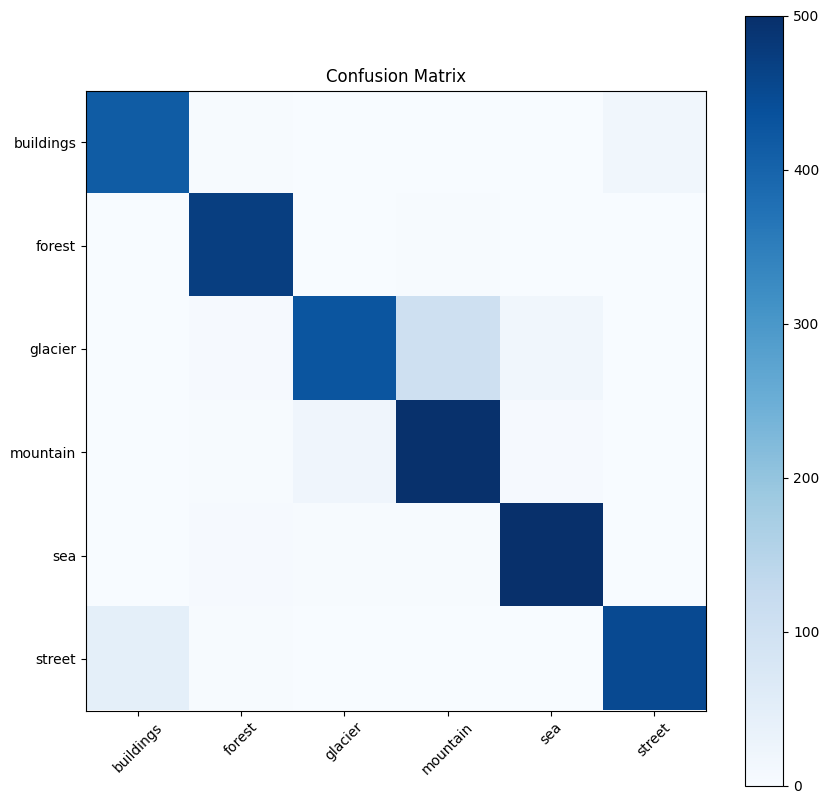

In [17]:
from tensorflow.math import confusion_matrix

cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(data_labels))
plt.xticks(tick_marks, data_labels, rotation=45)
plt.yticks(tick_marks, data_labels)
plt.colorbar()